In [3]:
import json
import os
import pandas as pd
from Bio import PDB
import matplotlib.pyplot as plt

In [8]:
def calculate_residue_plddt(directory, base_name):
    # Loop through the indices for the models
    all_residue_plddt = []
    for i in range(5):  # Models 0 to 4
        json_file = f"fold_{base_name}_full_data_{i}.json"
        cif_file = f"fold_{base_name}_model_{i}.cif"

        json_path = os.path.join(directory, json_file)
        cif_path = os.path.join(directory, cif_file)

        # Check if both files exist
        if os.path.exists(json_path) and os.path.exists(cif_path):
            # Load the JSON data
            with open(json_path) as json_data:
                plddts = json.load(json_data)['atom_plddts']

            # Parse the CIF file
            structure = PDB.MMCIFParser(QUIET=True).get_structure('model', cif_path)
            
            # Extract atom-to-residue information 
            atom_to_residue = [(chain.id, residue.resname, residue.id[1]) for model in structure for chain in model for residue in chain for atom in residue]

            # Create dataframe
            df = pd.DataFrame({
                'chain_id': [item[0] for item in atom_to_residue],
                'res_name': [item[1] for item in atom_to_residue],
                'res_id': [item[2] for item in atom_to_residue],
                'plddts': plddts
            })

            # Calculate the mean pLDDT for each residue
            residue_plddt = df.groupby(['chain_id', 'res_id']).agg(
                res_name=('res_name', 'first'),
                mean_plddt=('plddts', 'mean'),
                std_plddt=('plddts', 'std'),
            ).reset_index()

            # Calculate the coefficient of variation (CV)
            residue_plddt['cv_plddt'] = residue_plddt['std_plddt'] / residue_plddt['mean_plddt']

            # Add a column for the source file
            residue_plddt['model'] = f"model_{i}"

            # Append to the list
            all_residue_plddt.append(residue_plddt)

    # Concatenate dataframes
    all_residue_plddt_df = pd.concat(all_residue_plddt, ignore_index=True)

    # Plot CV pLDDT as a boxplot for all models
    plt.figure(figsize=(15, 6))
    all_residue_plddt_df.boxplot(column='cv_plddt', by='model', grid=False)
    plt.title(f"CVs of pLDDT for {base_name} Models")
    plt.suptitle('')  # Remove the default title to avoid duplication
    plt.xlabel('Model')
    plt.ylabel('CV of per-residue pLDDT')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return all_residue_plddt_df                             

<Figure size 1500x600 with 0 Axes>

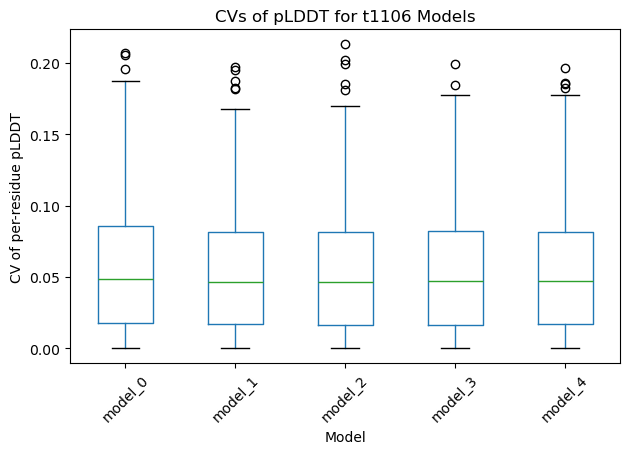

,chain_id,res_id,res_name,mean_plddt,std_plddt,cv_plddt,model
0,A,1,MET,32.923750,6.822207,0.207212,model_0
1,A,2,SER,33.043333,1.941285,0.058750,model_0
2,A,3,ARG,28.700909,5.892986,0.205324,model_0
3,A,4,ILE,33.417500,2.666489,0.079793,model_0
4,A,5,ILE,26.227500,1.583475,0.060375,model_0
...,...,...,...,...,...,...,...
1175,B,110,HIS,77.074000,9.952118,0.129124,model_4
1176,B,111,ASN,75.966250,6.998361,0.092125,model_4
1177,B,112,GLU,69.628889,9.305107,0.133639,model_4
1178,B,113,SER,71.785000,5.445559,0.075859,model_4


In [9]:
calculate_residue_plddt('af3_predictions/fold_t1106', 't1106')